# <center>CITS5017 Project 1<center>
<center>Allison Lau (23123849)<center>

# Import packages

In [37]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

# Load Image Dataset

In [3]:
def load_data(pickle_file):
    with open(pickle_file, "rb") as f:
        data_set = pickle.load(f)
    return data_set[b"data"], data_set[b"labels"], data_set[b"class_names"]

def resize_images(images, size=(96, 96)):
    images_resized = np.array([tf.image.resize(image, size).numpy() for image in images])
    return images_resized

# Call load_data to build the training and validation sets
X_train, y_train, class_names = load_data("train.pkl")
X_val, y_val, _ = load_data("val.pkl")

# Shuffle training and validation data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)

# Check shape of data : Image size = (64, 64, 3)
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# Resize images for MobileNetV2 model : Image size = (96, 96, 3)
X_train_resized = resize_images(X_train)
X_val_resized = resize_images(X_val)

# Check shape after resizing
print(f"Resized Training data shape: {X_train_resized.shape}")
print(f"Resized Validation data shape: {X_val_resized.shape}")

Training data shape: (2000, 64, 64, 3)
Validation data shape: (500, 64, 64, 3)
Resized Training data shape: (2000, 96, 96, 3)
Resized Validation data shape: (500, 96, 96, 3)


# Tasks
## (i) Display 20 sample images from training set and validation set

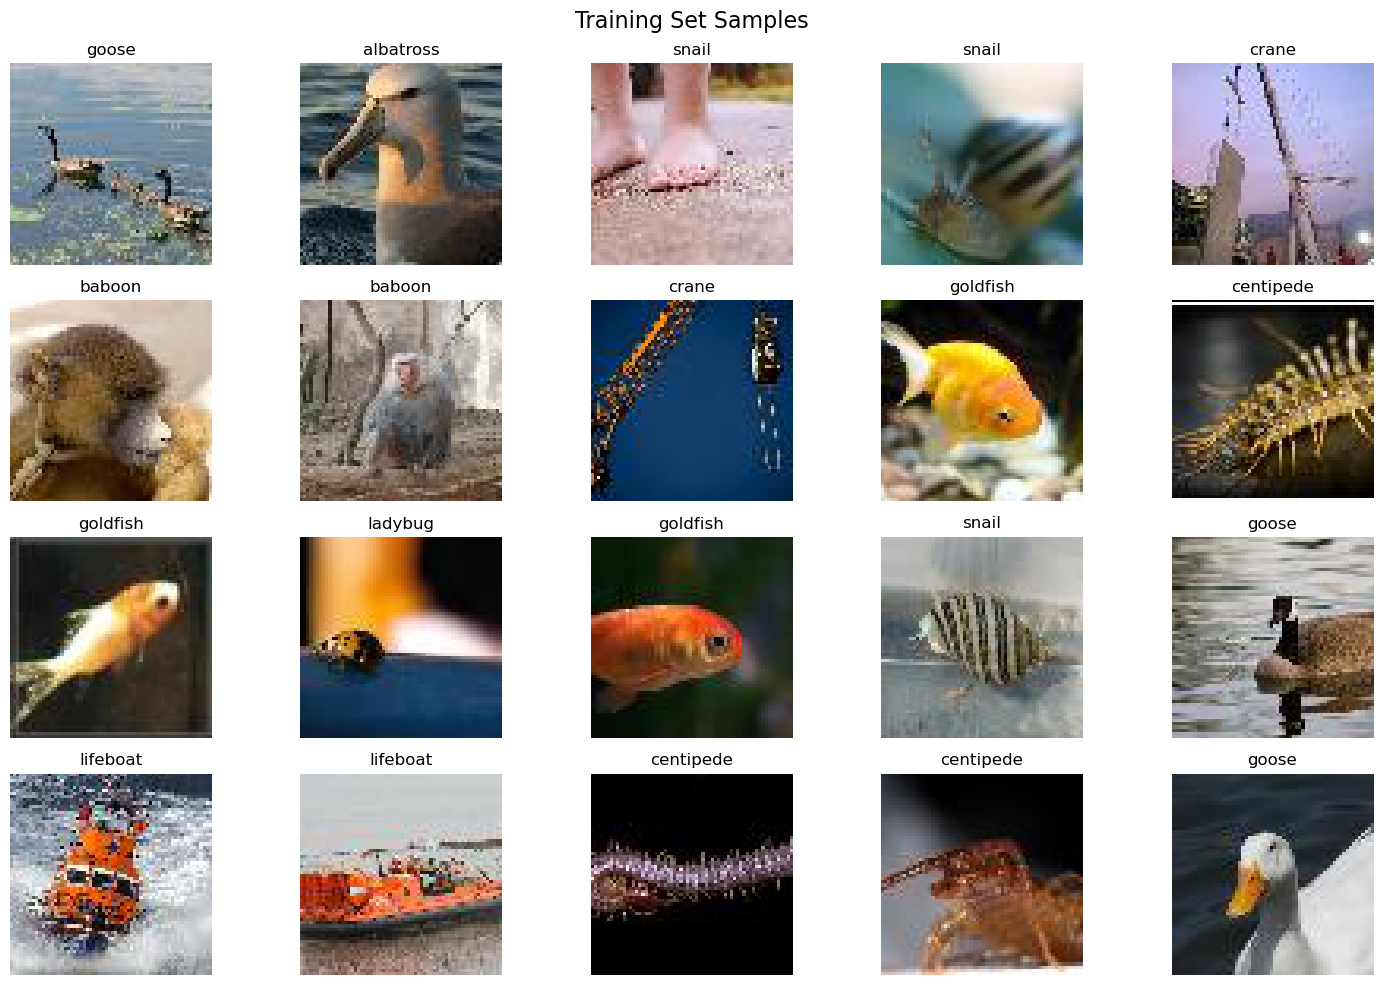

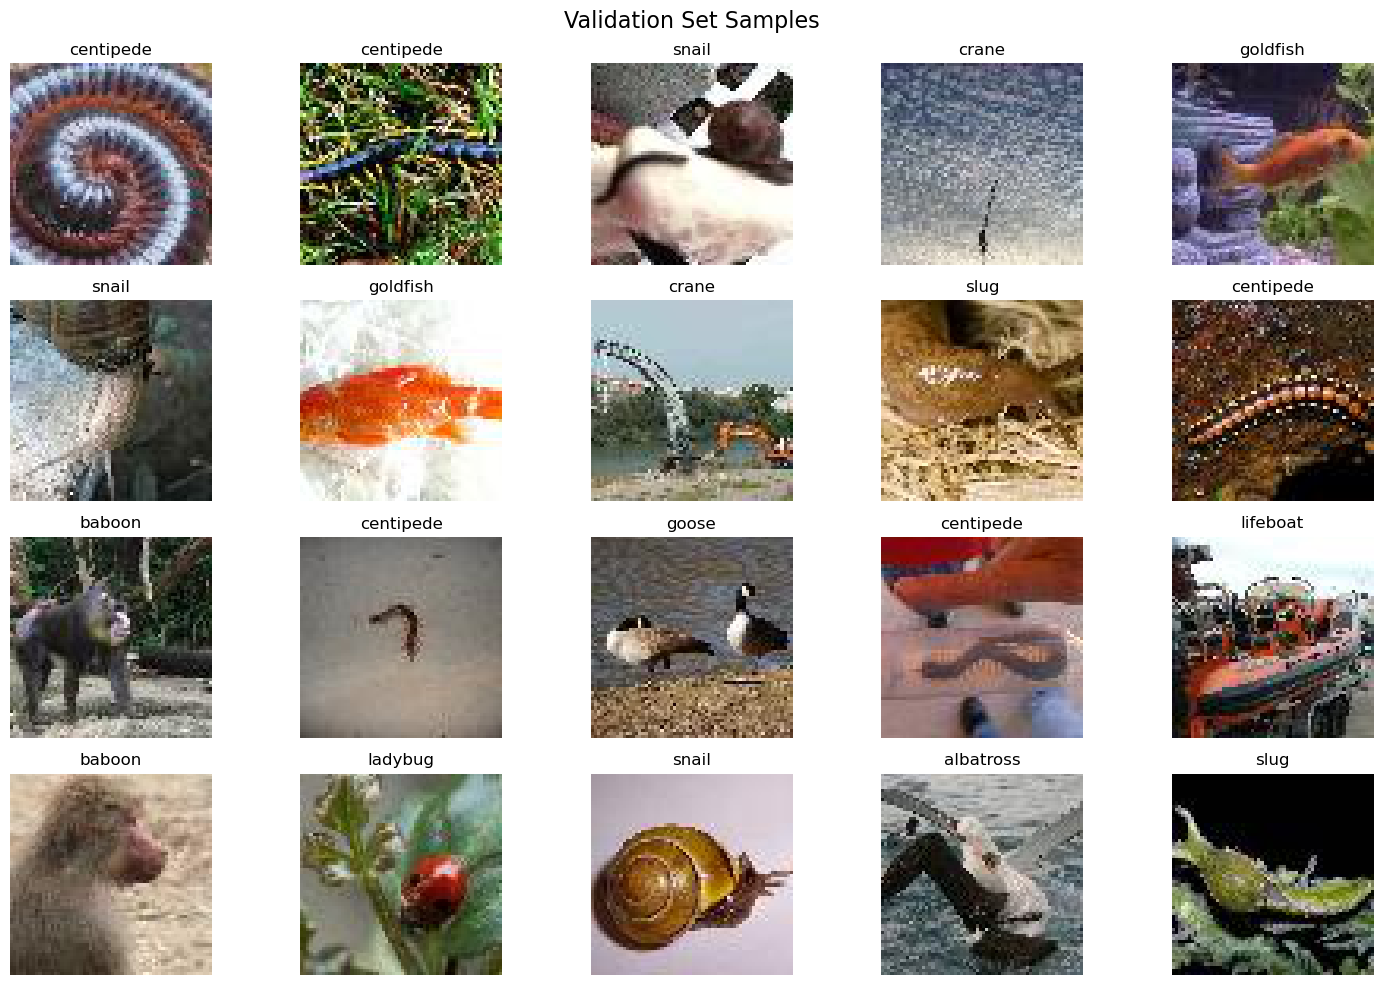

In [4]:
# Function to display 20 sample images from the dataset
def displayImages(images, labels, class_names, title):
    num_samples = 20
    indices = np.random.choice(images.shape[0], num_samples)
    sampled_images = images[indices]
    sampled_labels = labels[indices]
    
    fig, axes = plt.subplots(4, 5, figsize=(15, 10))
    
    for i, (image, label) in enumerate(zip(sampled_images, sampled_labels)):
        row = i // 5
        col = i % 5
        ax = axes[row, col]
        ax.imshow(image)
        ax.set_title(class_names[label])
        ax.axis("off")
    
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

displayImages(X_train, y_train, class_names, "Training Set Samples")
displayImages(X_val, y_val, class_names, "Validation Set Samples")

## (ii) Implementation of CNN Model
### Design of CNN architecture

In [34]:
# Function to create a CNN model
def create_cnn(kernel_size, num_kernels, dropout_rate):
    DefaultConv2D = partial(Conv2D, kernel_size=kernel_size, padding="same",
                            activation="relu", kernel_initializer="he_normal")
    model = Sequential([
        # Input Layer
        Conv2D(filters=num_kernels, kernel_size=kernel_size, input_shape=[64, 64, 3]),
        MaxPool2D(),
        BatchNormalization(),
        # Convolutional Layer
        Conv2D(filters=num_kernels*2),
        Conv2D(filters=num_kernels*2),
        MaxPool2D(),
        BatchNormalization(),
        # Convolutional Layer
        Conv2D(filters=num_kernels*4),
        Conv2D(filters=num_kernels*4),
        MaxPool2D(),
        BatchNormalization(),
        # Flatten and Fully Connected Layers
        Flatten(),
        Dense(units=128, activation="relu", kernel_initializer="he_normal"),
        Dropout(dropout_rate),
        Dense(units=64, activation="relu", kernel_initializer="he_normal"),
        Dropout(dropout_rate),
        # Output Layer
        Dense(units=len(class_names), activation="softmax")
    ])
    
    return model

# Train a CNN model
def train_cnn(model, X_train, y_train, X_val, y_val, num_epochs=100):
    # Compile model with exponential scheduling
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=0.01,
                    decay_steps=20_000,
                    decay_rate=0.1,
                    staircase=False
                    )
    optimizer = SGD(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train model
    history = model.fit(X_train, y_train, epochs=num_epochs,
                        validation_data=(X_val, y_val))
    
    # Evaluate model
    val_loss, val_acc = model.evaluate(X_val, y_val)

    return history, val_loss, val_acc

In [35]:
# Optimal hyperparameters
kernel_size = 3
num_kernels = 32
dropout_rate = 0.5

# Summary of CNN Architecture
cnn_model = create_cnn(kernel_size, num_kernels, dropout_rate)
cnn_model.summary()

c:\Users\allis\miniconda3\envs\cits5017-2024\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,336,266 (5.10 MB)

 Trainable params: 1,335,818 (5.10 MB)

 Non-trainable params: 448 (1.75 KB)

### Manual Hyperparameter Tuning
- hyperparameter tuning code
- hyperparameter values experimented
- optimal hyperparameter values

In [36]:
# Train CNN
history, val_loss, val_acc = train_cnn(cnn_model, X_train, y_train, X_val, y_val)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.1084 - loss: 3.8829 - val_accuracy: 0.1220 - val_loss: 3.0276
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.1400 - loss: 2.9121 - val_accuracy: 0.1720 - val_loss: 2.2553
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.1926 - loss: 2.5017 - val_accuracy: 0.2720 - val_loss: 2.1370
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.2056 - loss: 2.3482 - val_accuracy: 0.3000 - val_loss: 2.0798
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.2117 - loss: 2.2394 - val_accuracy: 0.2960 - val_loss: 2.0574
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.2499 - loss: 2.1532 - val_accuracy: 0.3220 - val_loss: 2.0409
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.2362 - loss: 2.1169 - val_accuracy: 0.3320 - val_loss: 2.0219
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.2836 - loss: 2.0473 - val_accuracy:

In [15]:
# Fixed hyperparameters
num_epochs = 100
batch_size = 32

# Experiment hyperparameters
kernel_sizes = [3, 5]
num_kernels_list = [32, 64]
dropout_rates = [0.3, 0.5]
optimal_hyperparameters = (kernel_size, num_kernels, dropout_rate)
highest_accuracy = 0.0

log_file = open("log.txt", "a", encoding="utf-8")

for kernel_size in kernel_sizes:
    for num_kernels in num_kernels_list:
        for dropout_rate in dropout_rates:
            # Create CNN
            cnn_model = create_cnn(kernel_size, num_kernels, dropout_rate)
            # Train CNN
            history, val_loss, val_acc = train_cnn(cnn_model, X_train, y_train, X_val, y_val, num_epochs, batch_size)
        
            # Save best performing hyperparameters
            if val_acc > highest_accuracy:
                highest_accuracy = val_acc
                optimal_hyperparameters = (kernel_size, num_kernels, dropout_rate)
            
            # Print and log results
            print(f"kernel_size={kernel_size}, num_kernels={num_kernels}, dropout_rate={dropout_rate}")
            print(f"- Validation accuracy: {val_acc}\n- Validation loss: {val_loss}\n")
            log_file.write(f"kernel_size={kernel_size}, num_kernels={num_kernels}, dropout_rate={dropout_rate}\n")
            log_file.write(f"- Validation accuracy: {val_acc}\n- Validation loss: {val_loss}\n")
log_file.close()

Epoch 1/100
32/63 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1679 - loss: 2.8315

KeyboardInterrupt: 

## (iii) Test CNN Model Implementation

In [16]:
# Function to plot learning curves on same figure
def plot_learning_curves(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    # Plot accuracy graph
    axs[0].plot(history.history['accuracy'], label='Training Set')
    axs[0].plot(history.history['val_accuracy'], label='Validation Set')
    axs[0].set_title('Accuracy over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    # Plot loss graph
    axs[1].plot(history.history['loss'], label='Training Set')
    axs[1].plot(history.history['val_loss'], label='Validation Set')
    axs[1].set_title('Loss over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    fig.suptitle('Learning Curves', fontsize=16)
    plt.tight_layout()
    plt.show()
    
# Training CNN Model
cnn_model_file = 'Lau_Allison-CNN.keras'

# Optimal hyperparameters
kernel_size = 5
num_kernels = 64
dropout_rate = 0.5
num_epochs = 100

if os.path.exists(cnn_model_file):
    # Load and display model summary
    cnn_model = tf.keras.models.load_model(cnn_model_file)
    print(f"Load '{cnn_model_file}' model successfully")
    
    # Compile the model with a tiny learning rate
    optimizer = Adam(learning_rate=1e-6)
    cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    cnn_model.summary()
    
    # Train the model for 1 more epoch
    cnn_history = cnn_model.fit(X_train, y_train, epochs=1,
                                validation_data=(X_val, y_val))
    
else:
    # Create CNN model
    cnn_model = create_cnn(kernel_size, num_kernels, dropout_rate)
    
    # Compile model with a learning rate schedule
    optimizer = Adam(learning_rate=0.001, decay=1e-4) # Power scheduling
    cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    cnn_model.summary()

    # Train the model with early stopping
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
    cnn_history = cnn_model.fit(X_train, y_train, epochs=num_epochs,
                                validation_data=(X_val, y_val),
                                callbacks=[early_stopping])
    
    # Save the model
    cnn_model.save(cnn_model_file)
    print(f"Save '{cnn_model_file}' model successfully")

    # Plot learning curves
    plot_learning_curves(cnn_history)

Load 'Lau_Allison-CNN.keras' model successfully


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 62, 62, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 31, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,561,290 (5.96 MB)

 Trainable params: 1,560,394 (5.95 MB)

 Non-trainable params: 896 (3.50 KB)

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.6325 - loss: 1.0220 - val_accuracy: 0.5200 - val_loss: 1.4254


### Evaluation of CNN Model

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Training Accuracy: 0.7965


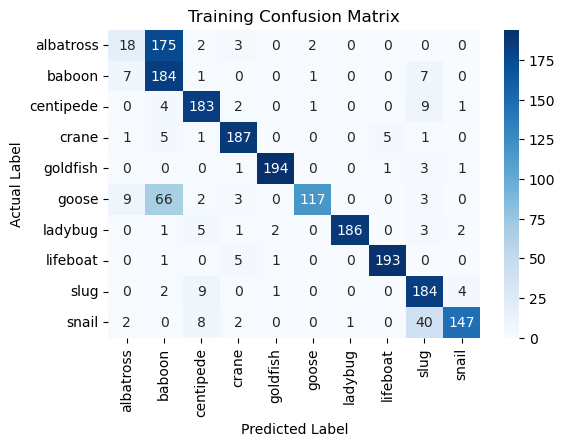

Validation Accuracy: 0.4900


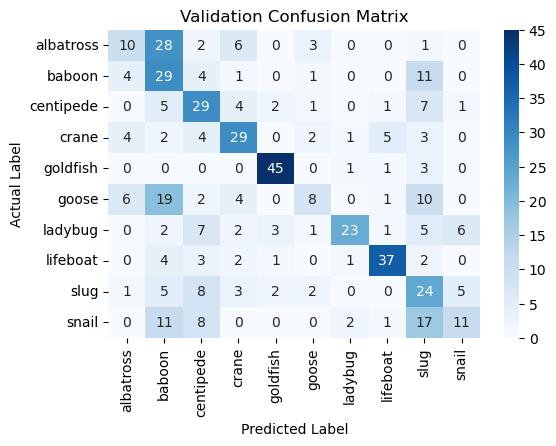

In [28]:
# Function to display confusion matrix
def display_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(title)
    plt.show()

# Function to evaluate a model
def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Perform predictions on training and validation sets
    y_train_pred = np.argmax(model.predict(X_train), axis=1)
    y_val_pred = np.argmax(model.predict(X_val), axis=1)
    
    # Compute prediction accuracy and confusion matrix
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    train_cm = confusion_matrix(y_train, y_train_pred)
    val_cm = confusion_matrix(y_val, y_val_pred)
    
    # Print
    print(f"Training Accuracy: {train_accuracy:.4f}")
    display_confusion_matrix(train_cm, "Training Confusion Matrix")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    display_confusion_matrix(val_cm, "Validation Confusion Matrix")

# Evaluate CNN model
evaluate_model(cnn_model, X_train, y_train, X_val, y_val)

## (iv) Transfer Learning using MobileNetV2

In [25]:
# Function to create MobileNetV2 model
def create_mobilenetv2(input_shape=(96, 96, 3), num_classes=10):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, 
                                                   weights='imagenet', 
                                                   input_shape=input_shape, 
                                                   pooling='avg')
    
    # Freeze the base model
    base_model.trainable = False
    
    # Adapt model to our Image dataset (10 classes)
    # model = tf.keras.models.Sequential([
    #     base_model,
    #     tf.keras.layers.Flatten(),
    #     tf.keras.layers.Dense(128, activation='relu'),
    #     tf.keras.layers.Dropout(0.5),
    #     tf.keras.layers.Dense(num_classes, activation='softmax')
    # ])
    
    return model

# Create the model
model = create_mobilenetv2()

# Display model architecture
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 60, 60, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 26, 26, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 13, 13, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 9, 9, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,564,363 (5.97 MB)

 Trainable params: 1,563,466 (5.96 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 1 (8.00 B)

In [36]:
# Training MobileNetV2 model
mnv2_model_file = 'Lau_Allison-MobileNetV2.keras'

# Create and compile the model
mnv2_model = create_mobilenetv2()
mnv2_model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Train the model
mnv2_history = mnv2_model.fit(X_train_resized, y_train, epochs=20, batch_size=32,
                         validation_data=(X_val_resized, y_val))

# Save the model
mnv2_model.save(mnv2_model_file)
print(f"Save '{mnv2_model_file}' model successfully")
    
# Plot learning curves
plot_learning_curves(mnv2_history)

In [ ]:
# Evaluate MobileNetV2 model
evaluate_model(mnv2_model, X_train_resized, y_train, X_val_resized, y_val)

## (v) Comparisons